## Import necessary modules and packages

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Loading the dataset

In [3]:
import os
base_dir = "/kaggle/input/raf-db-dataset"  # Base directory (where CSV files are)
source_dir = os.path.join(base_dir, "DATASET")  # Image source directory
target_dir = "/kaggle/working/rafdb"  # Destination for structured dataset

image_size = (100, 100)  
batch_size = 64

# Create necessary directories
for split in ["train", "test"]:
    for i in range(1, 8):  # Class labels 1 to 7
        os.makedirs(os.path.join(target_dir, split, str(i)), exist_ok=True)

# Load CSV files (Fixed paths)
train_df = pd.read_csv(os.path.join(base_dir, "train_labels.csv"))
test_df = pd.read_csv(os.path.join(base_dir, "test_labels.csv"))

In [4]:
import shutil

def organize_images(df, split):
    for _, row in df.iterrows():
        img_name = row.iloc[0]  
        label = str(row.iloc[1]) 

        img_path = os.path.join(source_dir, split, label, img_name)  
        dest_path = os.path.join(target_dir, split, label, img_name)

        if os.path.exists(img_path):
            shutil.copy(img_path, dest_path)
        else:
            print(f"Image not found: {img_path}")

# Run image organization
organize_images(train_df, "train")
organize_images(test_df, "test")

print("Dataset organized successfully!")

Dataset organized successfully!


In [5]:
print(os.listdir(os.path.join(target_dir, "train", "1"))[:10])

['train_06139_aligned.jpg', 'train_07414_aligned.jpg', 'train_05035_aligned.jpg', 'train_01109_aligned.jpg', 'train_06385_aligned.jpg', 'train_07908_aligned.jpg', 'train_02604_aligned.jpg', 'train_04319_aligned.jpg', 'train_00793_aligned.jpg', 'train_04229_aligned.jpg']


## EDA

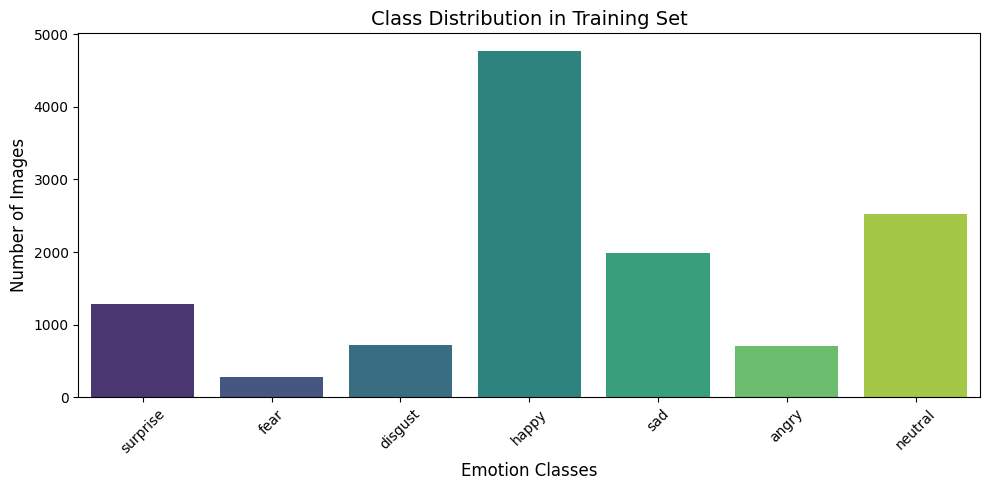

Class-wise Image Counts:
1 (surprise): 1290 images
2 (fear): 281 images
3 (disgust): 717 images
4 (happy): 4772 images
5 (sad): 1982 images
6 (angry): 705 images
7 (neutral): 2524 images


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

number_to_label = {
    "1": "surprise",
    "2": "fear",
    "3": "disgust",
    "4": "happy",
    "5": "sad",
    "6": "angry",
    "7": "neutral"
}

# Get folder names (i.e., class numbers as strings)
class_labels = sorted(os.listdir(os.path.join(target_dir, "train")))  # ['1', '2', ..., '7']

# Count the number of images in each class
class_counts = {
    label: len(os.listdir(os.path.join(target_dir, "train", label)))
    for label in class_labels
}

# Plot class distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=pd.Series([number_to_label[label] for label in class_counts.keys()]),y=list(class_counts.values()),palette="viridis")


# Plot labels and title
plt.xlabel("Emotion Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution in Training Set", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print class-wise counts
print("Class-wise Image Counts:")
for label in class_counts:
    print(f"{label} ({number_to_label[label]}): {class_counts[label]} images")

### There is a data imbalance among different classes which make model to be biased to the classes having more number of samples

In [7]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation settings
datagen = ImageDataGenerator(
    brightness_range=[0.8, 1.2],  # Random brightness
    horizontal_flip=True,
    rotation_range=30,  
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zoom
    fill_mode='nearest'  # Fill missing pixels
)

def augment_class_images(class_folder, target_count):
    # Get all image files in the class folder
    images = [img for img in os.listdir(class_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(images)

    if current_count >= target_count:
        print(f"Class {os.path.basename(class_folder)} already has {current_count} images.")
        return
    
    print(f"Augmenting class {os.path.basename(class_folder)}: {current_count} ➝ {target_count}")

    # Generate new images
    i = 0
    while current_count < target_count:
        img_name = images[i % len(images)]  # Cycle through existing images
        img_path = os.path.join(class_folder, img_name)
        
        # Load image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Generate augmented image
        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)

        # Save new image
        aug_name = f"aug_{current_count}.jpg"
        cv2.imwrite(os.path.join(class_folder, aug_name), cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        current_count += 1
        i += 1  # Move to next image

    print(f"Augmentation complete for {os.path.basename(class_folder)}!")

# Define dataset path
dataset_dir = "/kaggle/working/rafdb/train"  # Update this to your actual dataset path

# Augment each class to 5000 images
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        augment_class_images(class_path, target_count=5000)

print("Dataset balancing complete!")

Augmenting class 6: 705 ➝ 5000
Augmentation complete for 6!
Augmenting class 1: 1290 ➝ 5000
Augmentation complete for 1!
Augmenting class 2: 281 ➝ 5000
Augmentation complete for 2!
Augmenting class 4: 4772 ➝ 5000
Augmentation complete for 4!
Augmenting class 7: 2524 ➝ 5000
Augmentation complete for 7!
Augmenting class 5: 1982 ➝ 5000
Augmentation complete for 5!
Augmenting class 3: 717 ➝ 5000
Augmentation complete for 3!
Dataset balancing complete!


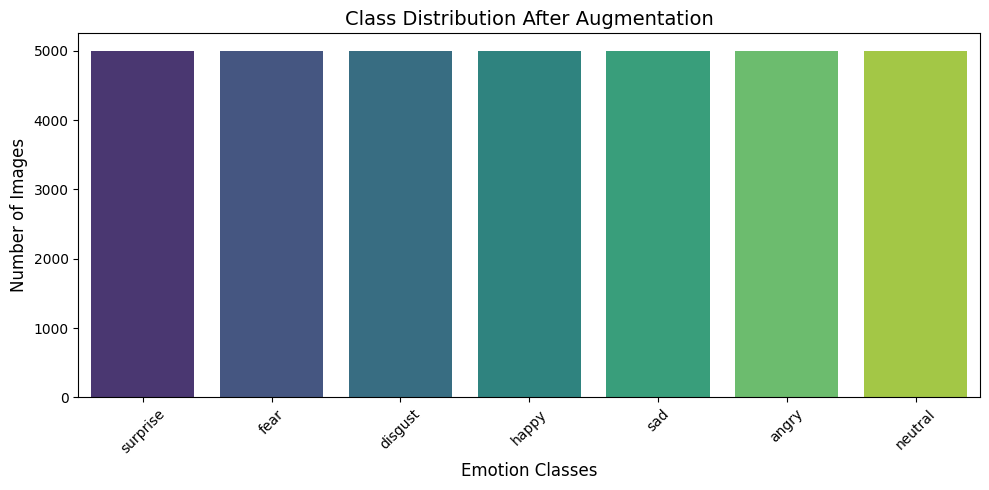

Class-wise Image Counts After Augmentation:
1 (surprise): 5000 images
2 (fear): 5000 images
3 (disgust): 5000 images
4 (happy): 5000 images
5 (sad): 5000 images
6 (angry): 5000 images
7 (neutral): 5000 images


In [8]:
# Plot after augmentation
class_labels = sorted(os.listdir(os.path.join(target_dir, "train")))  # Ensures 1–7 order

class_counts = {
    label: len(os.listdir(os.path.join(target_dir, "train", label)))
    for label in class_labels
}

plt.figure(figsize=(10, 5))
sns.barplot(x=pd.Series([number_to_label[label] for label in class_counts.keys()]),y=list(class_counts.values()), palette="viridis")

plt.xlabel("Emotion Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Augmentation", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print class-wise counts
print("Class-wise Image Counts After Augmentation:")
for label in class_counts:
    print(f"{label} ({number_to_label[label]}): {class_counts[label]} images")

### Data is balanced which prevent model to be bias

## Sample images

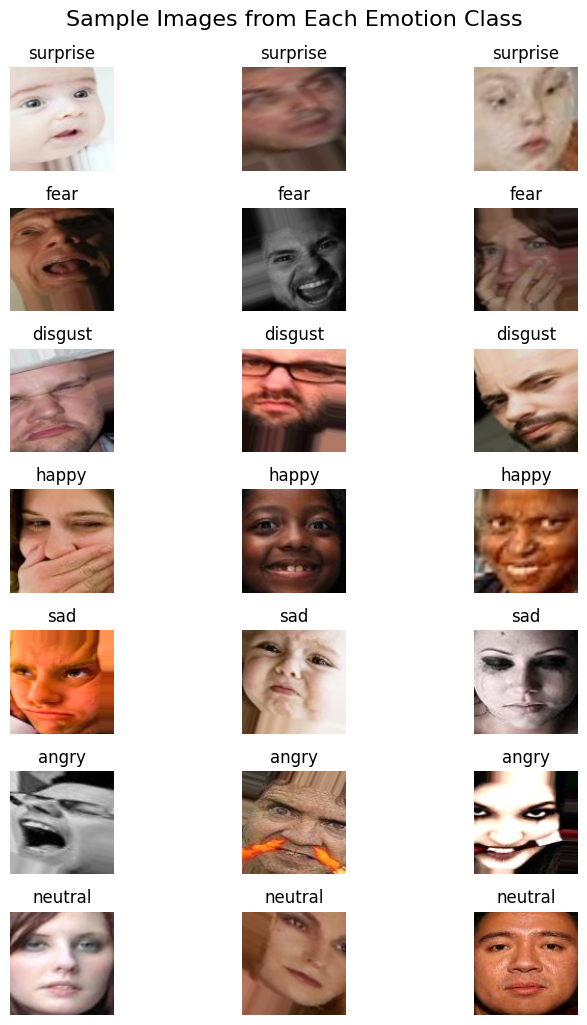

In [11]:
import random
from PIL import Image
# Number of images to display per class
samples_per_class = 3

# Image display size
img_size = (100, 100)  # Resize to show thumbnails

# Display few images per class
plt.figure(figsize=(8, 10))

i = 1
for class_num, emotion in number_to_label.items():
    class_dir = os.path.join(target_dir, "train", class_num)
    image_files = os.listdir(class_dir)
    sample_files = random.sample(image_files, samples_per_class)

    for img_name in sample_files:
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).resize(img_size)

        plt.subplot(len(number_to_label), samples_per_class, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(emotion)
        i += 1

plt.tight_layout()
plt.suptitle("Sample Images from Each Emotion Class", fontsize=16, y=1.02)
plt.show()

## Model 1

In [13]:
from tensorflow.keras.applications.densenet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,   
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Improved Data Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(target_dir, "train"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(target_dir, "train"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(target_dir, "test"),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

print("Data Generators Ready!")

Found 28000 images belonging to 7 classes.
Found 7000 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.
Data Generators Ready!


In [14]:
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adam

classes = 7

base_model = DenseNet121(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
base_model.trainable = True  


x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)

x = layers.Dense(256, activation='relu', 
                kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.Dropout(0.6)(x) 

x = layers.Dense(128, activation='relu',
                kernel_regularizer=regularizers.l2(0.0005))(x)
x = layers.Dropout(0.6)(x)
predictions = layers.Dense(classes, activation='softmax')(x)

model_DenseNet121 = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
model_DenseNet121.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 106, 106, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 25, 25, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 25, 25, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 25, 25, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,337,799 (27.99 MB)

 Trainable params: 7,252,103 (27.66 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [ ]:
# Compile the model
model_DenseNet121.compile(
    optimizer=Adam(learning_rate=0.00002),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Callback functions
def get_callbacks(model_name):
    return [
        ModelCheckpoint(filepath=f'model.{model_name}.keras', verbose=1, monitor='val_accuracy', mode='max', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    ]

In [31]:
from tensorflow.keras.callbacks import *
callbacks = get_callbacks('DenseNet121')

In [32]:
history_DenseNet121 = model_DenseNet121.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=100,  
    batch_size=64,  
    callbacks=callbacks
)

Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.1235 - loss: 3.4976
Epoch 1: val_accuracy improved from -inf to 0.17374, saving model to model.DenseNet121.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 214s 700ms/step - accuracy: 0.1236 - loss: 3.4965 - val_accuracy: 0.1737 - val_loss: 2.2729
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1831 - loss: 2.9273
Epoch 2: val_accuracy improved from 0.17374 to 0.38581, saving model to model.DenseNet121.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/step - accuracy: 0.1832 - loss: 2.9266 - val_accuracy: 0.3858 - val_loss: 1.9935
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2365 - loss: 2.6703
Epoch 3: val_accuracy improved from 0.38581 to 0.43108, saving model to model.DenseNet121.keras
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 286ms/step - accuracy: 0.2366 - loss: 2.6699 - val_accuracy: 0.4311 - val_loss: 1.8627
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2783 - loss: 2.507

## Results on model 1

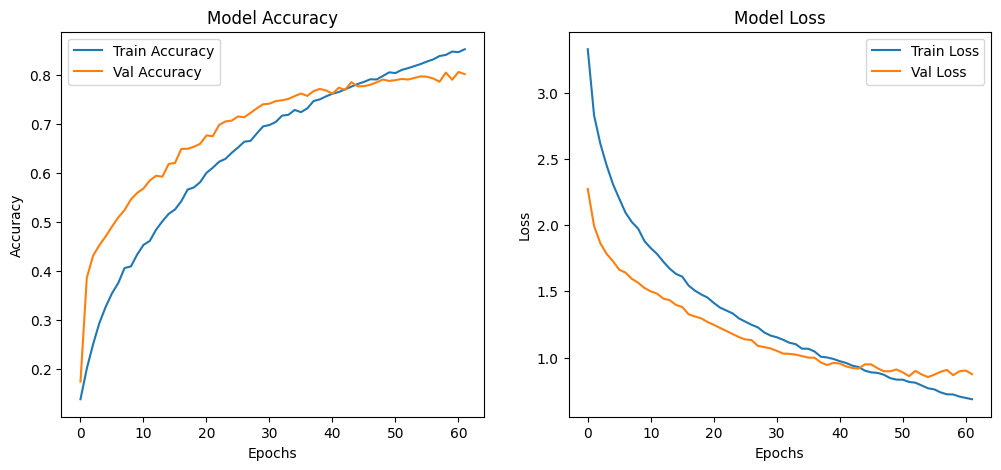

In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history_DenseNet121)

In [34]:
test_loss, test_acc = model_DenseNet121.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8064 - loss: 0.8316
Test Accuracy: 80.38%


Found 3068 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step


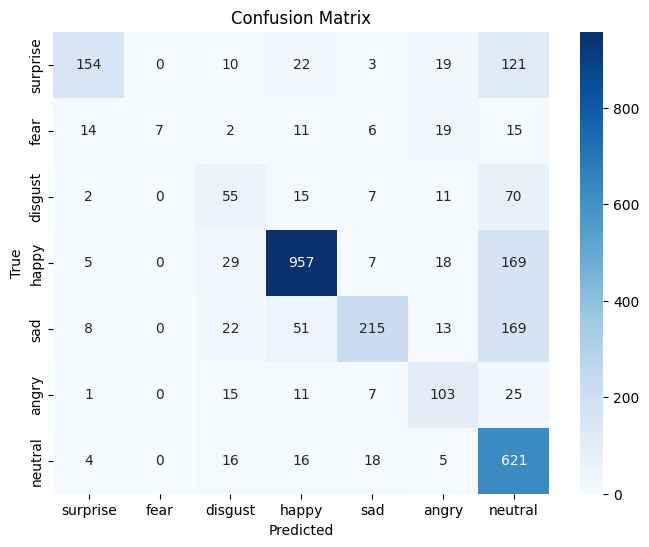

In [21]:
from sklearn.metrics import confusion_matrix

# Emotion labels mapping
emotion_labels = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']

# Predict on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with emotion labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


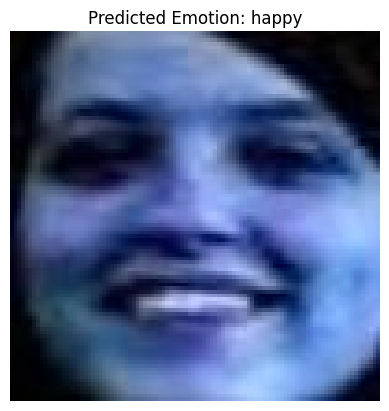

In [15]:
image = cv2.imread('/kaggle/input/raf-db-dataset/DATASET/test/4/test_0009_aligned.jpg') # Ground truth label of image is happy
image = cv2.resize(image, (100, 100))  # Resize to match input shape
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image_normalized = image_rgb / 255.0  # Normalize pixel values
image_input = np.expand_dims(image_normalized, axis=0)  

prediction = model.predict(image_input)
emotion_index = np.argmax(prediction)
predicted_emotion = emotion_labels[emotion_index]

# Display image with predicted label
plt.imshow(image_rgb)
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')
plt.show()

## Model 2

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_custom_cnn(input_shape=(100, 100, 3), num_classes=7):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Block 4
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # 7 emotion classes

    return model

In [22]:
model = create_custom_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,751,687 (10.50 MB)

 Trainable params: 2,750,727 (10.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
from tensorflow.keras.callbacks import *
callbacks = get_callbacks('model')

In [24]:
history1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=100,  
    batch_size=64,  
    callbacks=callbacks
)

Epoch 1/100
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.1783 - loss: 2.4017
Epoch 1: val_accuracy improved from -inf to 0.19857, saving model to model.model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 131s 278ms/step - accuracy: 0.1783 - loss: 2.4000 - val_accuracy: 0.1986 - val_loss: 3.0085
Epoch 2/100
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.1884 - loss: 1.9123
Epoch 2: val_accuracy improved from 0.19857 to 0.21271, saving model to model.model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 116s 260ms/step - accuracy: 0.1884 - loss: 1.9123 - val_accuracy: 0.2127 - val_loss: 1.9176
Epoch 3/100
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.1985 - loss: 1.8941
Epoch 3: val_accuracy improved from 0.21271 to 0.23929, saving model to model.model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 117s 265ms/step - accuracy: 0.1985 - loss: 1.8940 - val_accuracy: 0.2393 - val_loss: 1.8663
Epoch 4/100
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2045 - loss: 1.8850
Epoch 4: val_a

## Results of model 2

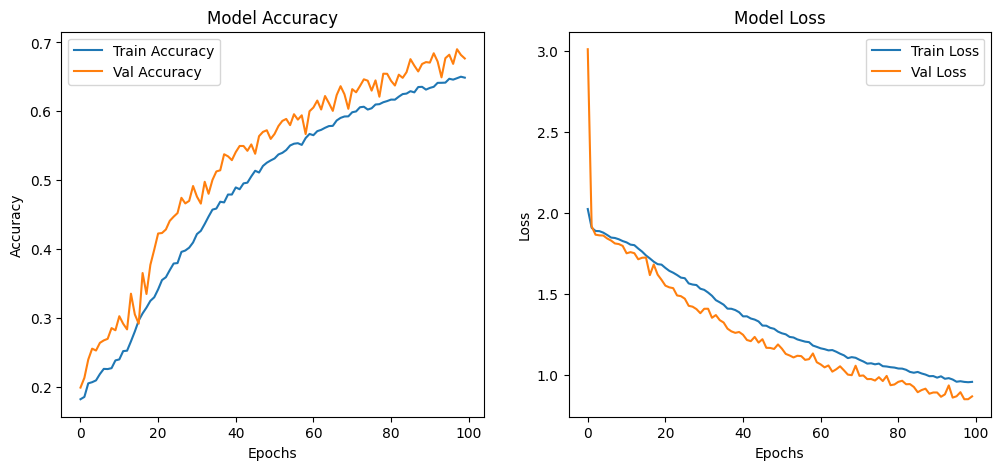

In [25]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history1)

In [26]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7770 - loss: 0.6442
Test Accuracy: 78.75%


Found 3068 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step


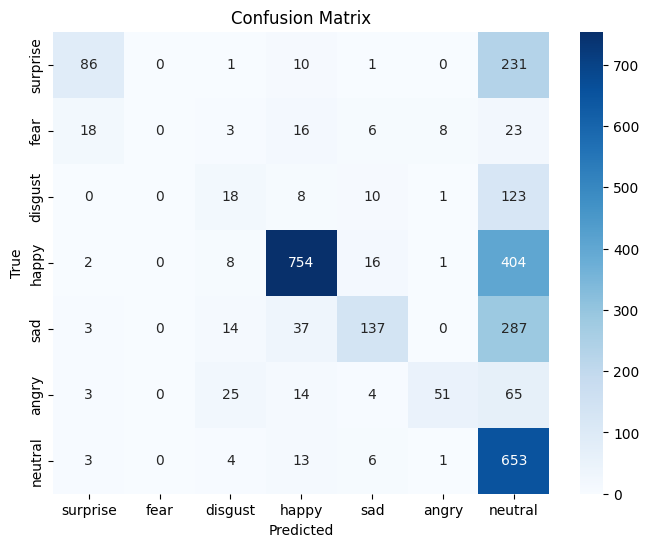

In [22]:
from sklearn.metrics import confusion_matrix

# Emotion labels mapping
emotion_labels = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']

# Predict on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with emotion labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


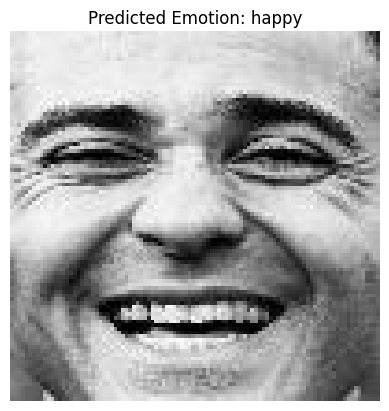

In [18]:
image = cv2.imread('/kaggle/input/raf-db-dataset/DATASET/test/4/test_0013_aligned.jpg')  # Ground truth label of image is happy
image = cv2.resize(image, (100, 100))  # Resize
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
image_normalized = image_rgb / 255.0  # Normalize
image_input = np.expand_dims(image_normalized, axis=0) 

# Predict expression
prediction = model.predict(image_input)
emotion_index = np.argmax(prediction)
emotion_labels = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
predicted_emotion = emotion_labels[emotion_index]

plt.imshow(image)
plt.title(f"Predicted Emotion: {predicted_emotion}")
plt.axis('off')  
plt.show()